In [182]:
#### imports ####

import numpy as np
from numpy.polynomial.hermite import hermgauss
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline

%matplotlib inline

####################################

plt.rcParams['figure.figsize'] = (8, 4)   
plt.rcParams['font.size'] = 16         
plt.rcParams['axes.titlesize'] = 16     
plt.rcParams['legend.fontsize'] = 14    
plt.rcParams['savefig.dpi'] = 150       
plt.rcParams['axes.labelsize'] = 16   

min_slice = 65000
max_slice = 70000

gh_degree = 25
gausshermite_xi_deg, gausshermite_wi_deg = np.polynomial.hermite.hermgauss(
    int(gh_degree))
YY1, YY2 = np.meshgrid(gausshermite_xi_deg, gausshermite_xi_deg, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg, gausshermite_wi_deg, indexing='ij')


In [283]:

target_redshift = 3.8
safe_z = str(target_redshift).replace('.', '-')

####################################

seed = 100       # for repeatability
size = 2**22
dv   = 1.0
# dv = 0.5

c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)

PD13_PIVOT_K = 0.009  # note: k_0
PD13_PIVOT_Z = 3.0    # note: z0 = 3

def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

# fitting parameters from mean flux           
tau0_fid   = 673.77e-3
tau1_fid   = 5.31008
nu_fid     = 2.16175
sigma2_fid = 1.50381
# sigma2_fid = 1.2

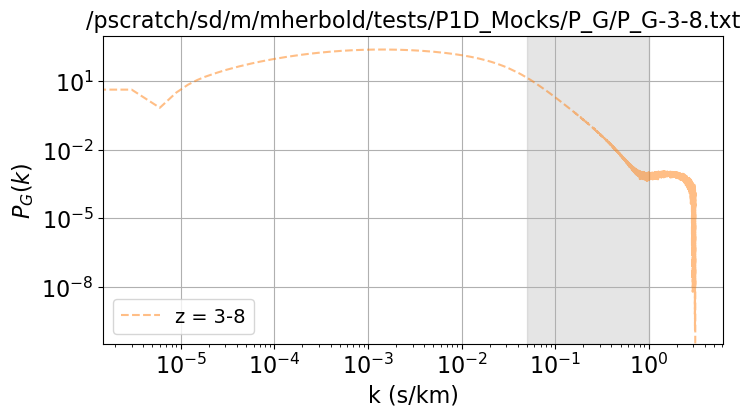

In [284]:

#### IMPORT P_G FILE ####

PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
# test_PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/test_P_G-{safe_z}.txt'
data = np.loadtxt(PG_file_path)
# data_test = np.loadtxt(test_PG_file_path)

# Split into k and P(k)
k_array = data[:, 0]
power_array = data[:, 1]
# k_array_test = data_test[:, 0]
# power_array_test = data_test[:, 1]

plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', 
           color='tab:orange',  ls='--', alpha=0.5)
# plt.loglog(k_array_test, power_array_test, label=f'test, new', 
#            color='tab:blue',  ls='dotted', alpha=0.5)
plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.legend()
plt.grid(True)
plt.title(f'{PG_file_path}')
plt.show()


In [291]:

#### FUNCTIONS ####

def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    """
    Transforms a Gaussian white noise field in k-space to a correlated
    Gaussian field in velocity-space, using an imported power spectrum.

    Parameters:
    - file_k_array: array of k values from the baseline power spectrum file [s/km]
    - file_power_array: array of P(k) values (baseline power)
    - gaussian_random_field_k: white noise field in rfft space
    - dv: spacing of the velocity grid [km/s]

    Returns:
    - delta_b_tilde: scaled k-space field
    - delta_b: real-space Gaussian field
    - P_k: interpolated and used power spectrum
    """
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # real-space size
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k [1/km]
    
    # Interpolate with smooth spline and constant extrapolation
    power_interp = InterpolatedUnivariateSpline(file_k_array, 
                                                file_power_array, 
                                                k=1, ext=1)
    P_k = power_interp(k)

    # Ensure non-negative and finite
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)

    # Scale the white noise in k-space
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)
    # delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k)

    # Inverse FFT to get real-space correlated Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N) / dv
    # delta_b = np.fft.irfft(delta_b_tilde, n=N) / (N * dv)

    return delta_b_tilde, delta_b, P_k


def a2_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.power((1. + zp) / (1.+z0), -nu)


def a_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))


def lognormal_transform(delta_z, sigma2_z):     # note: variance of the field, NOT the oneset by mean flux
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)


def t_of_z(zp, tau0=tau0_fid, tau1=tau1_fid, z0= PD13_PIVOT_Z):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)


def x_of_z(t_z, n_z):
    return t_z * n_z


def f_of_z(x_z):
    return np.exp(-x_z)

def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)


def xz(z, sigma2=sigma2_fid, tau0=tau0_fid, tau1=tau1_fid, 
       nu=nu_fid, z0=PD13_PIVOT_Z):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)


# note: pass variance of the field, not sigma2 the variable
def mean_flux(z, variance, z0=PD13_PIVOT_Z):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)


def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)


def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    # f_bar = input_flux.mean()
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)


def P_F(delta_f, dv):
    L = delta_f.size * dv
    delta_f_tilde = np.fft.rfft(delta_f) * dv
    P_F = np.abs(delta_f_tilde)**2 / L
    return P_F


def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f, dv)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    w_k =  (kmodes > 0) & (kmodes < 10e1)   
    bins = 10000
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[w_k],
                                                       values=power[w_k],
                                                       statistic='mean', 
                                                       bins = bins)    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
 
    # window = (bin_centers > 1e-5) & (bin_centers < 0.10)  
    window = (bin_centers > 0) & (bin_centers < 1.0)  
    # Remove invalid points
    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    # Initial guess
    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    # Now safe to call curve_fit
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)
    
    return bin_centers[window], statistic[window], *popt_mock
    # return bin_centers, statistic, *popt_mock


def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result


DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)


Naim_2020_param = (
    0.066, -2.685, -0.22, 
    3.59, -0.18, 0.53)

In [292]:

#### MOCK GENERATION ####

gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) #+ 1e-12 

delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array, power_array, gaussian_random_field_k, dv)

variance_1d = sigma2_fid
variance_1d_field = delta_b_v.var()

delta_b_z = delta_b_v * a_z(zp = target_redshift)
redshifted_variance_1d = variance_1d * a2_z(zp = target_redshift)
redshifted_variance_1d_field = variance_1d_field * a2_z(zp = target_redshift)

n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
t_z = t_of_z(zp=target_redshift)
x_z = x_of_z(t_z, n_z)
f_z = f_of_z(x_z)

delta_f = delta_F(z=target_redshift, 
                  variance=variance_1d, 
                  input_flux=f_z)
# delta_f = delta_F(z=target_redshift, 
#                   variance=variance_1d_field, 
#                   input_flux=f_z)

test_power = P_F(delta_f, dv)
N = len(delta_f)
kmodes2 = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi



/tmp/ipykernel_1915713/3366965622.py:80: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))


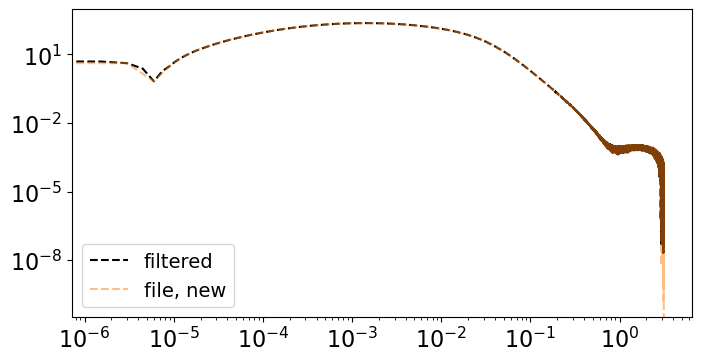

In [293]:
# plt.loglog(kmodes[1:], P_k_filtered[1:], label='filtered', color='black', ls='--')
plt.loglog(kmodes, P_k_filtered, label='filtered', color='black', ls='--')


plt.loglog(k_array, power_array, label=f'file, new', 
           color='tab:orange',  ls='--', alpha=0.5)

# plt.loglog(k_array_test, power_array_test, label=f'file, old', 
#            color='tab:blue',  ls='dotted', alpha=0.5)


# plt.xlim(10e-6)
plt.legend(loc='lower left')

/tmp/ipykernel_1915713/3366965622.py:80: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))


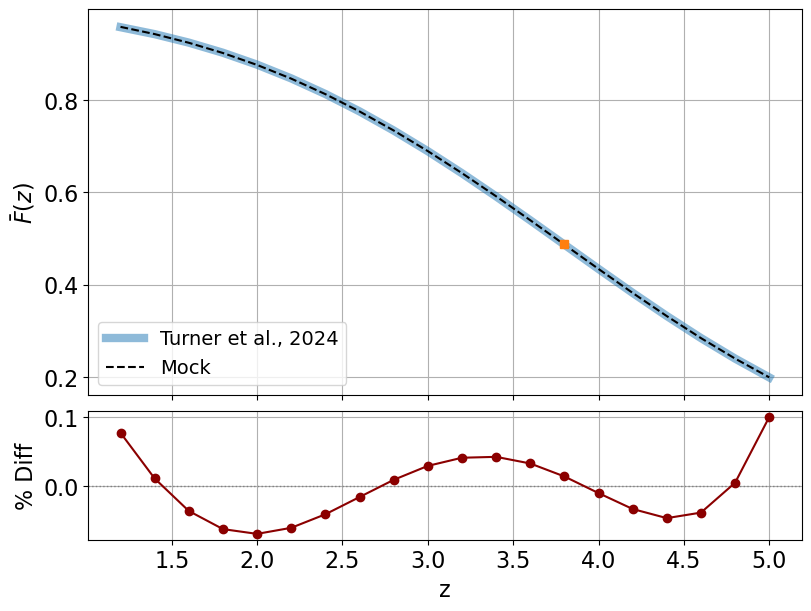

In [294]:

#### CHECK MEAN FLUX ####

z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5.0])
flux_list = []
for i in z_list:
    flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))
turner_flux = turner24_mf(z_list)
residuals = 100 * (flux_list - turner_flux) / turner_flux

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), 
                               gridspec_kw={'height_ratios': [3, 1]}, 
                               constrained_layout=True)

ax1.plot(z_list, turner_flux, label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(z_list, flux_list, label='Mock', ls='--', color='black')
ax1.plot(target_redshift, f_z.mean(), 's')
ax1.set_ylabel(r'$\bar F(z)$')
ax1.legend(loc='lower left')
ax1.grid()

ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(z_list, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()
plt.show()


In [295]:

#### MEASURE POWER ####

delta_f = delta_F(z=target_redshift, 
                  variance=variance_1d, 
                  input_flux=f_z)
# delta_f = delta_F(z=target_redshift, 
#                   variance=variance_1d_field, 
#                   input_flux=f_z)

test_power = P_F(delta_f, dv)

bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, 
                                                      target_redshift)

mock_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *popt_mock_param)
desi_model = evaluatePD13Lorentz((bin_centers, target_redshift), 
                                 *DESI_EDR_PARAMETERS)
naim_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *Naim_2020_param)

percent_diff_mock_measure = 100 * (stat - desi_model) / desi_model
percent_diff_mock_fit     = 100 * (mock_fit - desi_model) / desi_model
percent_diff_naim_fit     = 100 * (naim_fit - desi_model) / desi_model


/tmp/ipykernel_1915713/3366965622.py:80: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))
/tmp/ipykernel_1915713/3366965622.py:142: RuntimeWarning: overflow encountered in power
  result = (A * np.pi / PD13_PIVOT_K) * np.power(
/tmp/ipykernel_1915713/3366965622.py:146: RuntimeWarning: overflow encountered in power
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_1915713/3366965622.py:146: RuntimeWarning: overflow encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_1915713/3366965622.py:146: RuntimeWarning: invalid value encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)


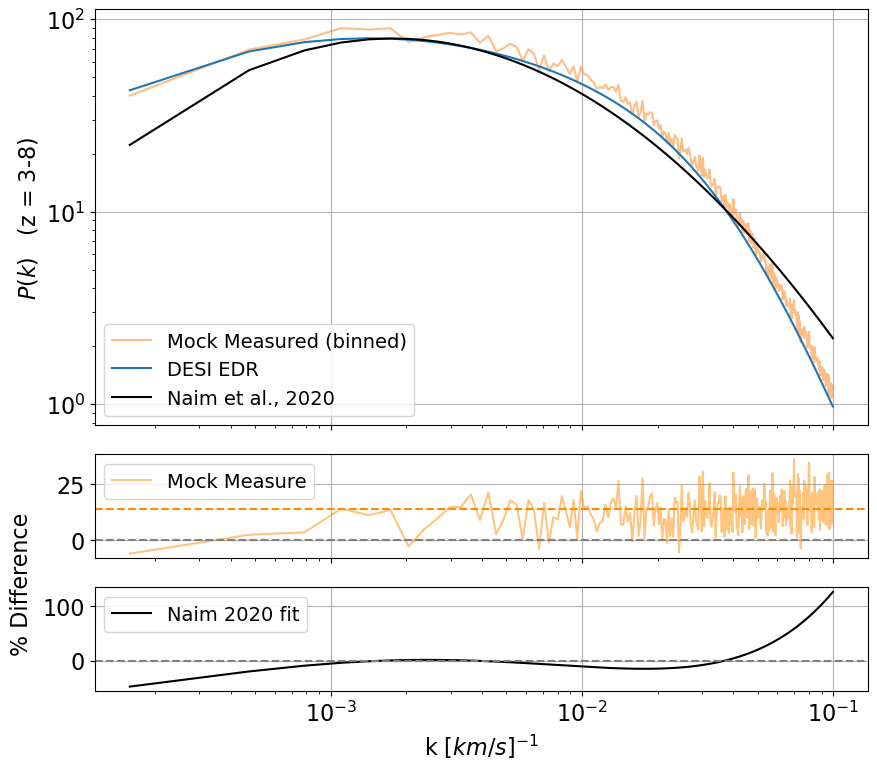

Average % difference: 13.68593186366009
Max % difference:     36.2854050355757


In [296]:

#### PLOT MEASURED POWER ####

w_k = (bin_centers > 1e-5) & (bin_centers < 0.1) 
# w_k = (bin_centers > 1e-5) & (bin_centers < 1.0) 


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True, 
                                    gridspec_kw={'height_ratios': [4, 1, 1]})

ax1.loglog(bin_centers[w_k], stat[w_k], color='tab:orange', 
           label='Mock Measured (binned)', alpha=0.5)
# ax1.loglog(bin_centers, mock_fit, color='tab:orange', 
#            label='Mock Fit (PD13)', lw=2)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
           color='tab:blue', label=r'DESI EDR')
ax1.loglog(bin_centers[w_k], naim_fit[w_k], 
    color='black', label=r'Naim et al., 2020')


# ax1.loglog(kmodes, test_power, alpha=0.2, label='unbinned')

# ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.set_ylabel(rf'$P(k)$   (z = {safe_z})')
ax1.legend(loc='lower left')
ax1.grid(True)
# ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')
# ax1.axvspan(0.05, 1.0, alpha=0.2, color='grey')


ax2.semilogx(bin_centers[w_k], percent_diff_mock_measure[w_k], alpha=0.5,
             color='darkorange', label='Mock Measure')
ax2.axhline(percent_diff_mock_measure[w_k].mean(), ls='--', color='darkorange')
# ax2.semilogx(bin_centers, percent_diff_mock_fit, 
#              color='darkred', label='Mock Fit')
ax2.axhline(0, ls='--', color='gray')
# ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.semilogx(bin_centers[w_k], percent_diff_naim_fit[w_k], 
             color='black', label='Naim 2020 fit')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel(r'k $[km/s]^{-1}$')
# ax3.set_ylabel('% Diff')
ax3.grid(True)
# ax3.set_xlim(bin_centers.min() -10, bin_centers.max())

fig.text(0.02, 0.25, "% Difference", va='center', rotation='vertical', fontsize=16)
ax3.set_ylabel("")  # remove individual y-labels to avoid overlap

plt.legend()
plt.tight_layout()

# plt.xlim(10e-4, 10e-2)
# ax1.set_ylim(10e-2, 10e2)

plt.show()

print(f'Average % difference: {percent_diff_mock_measure[w_k].mean()}')
print(f'Max % difference:     {percent_diff_mock_measure[w_k].max()}')


### COMPARE TO DESI EDR DATA

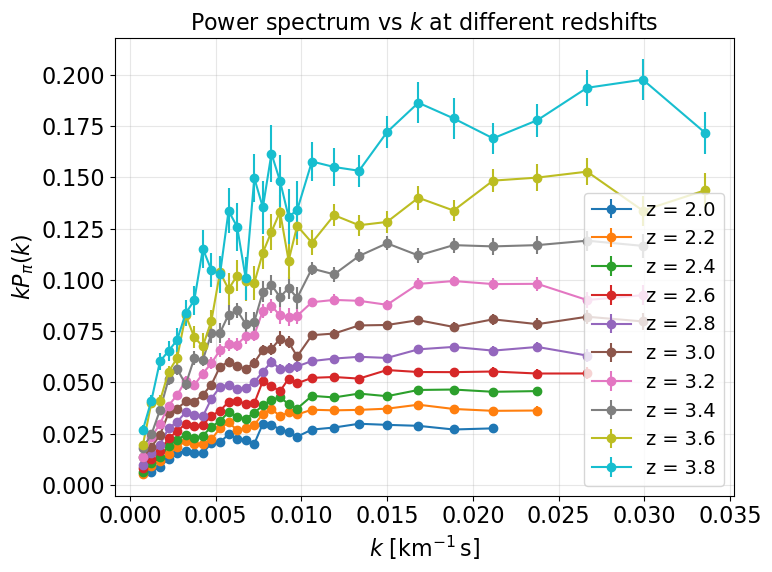

In [297]:
import pandas as pd

edr_data_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Examples/figure8_qmle_desiedrp_results.txt'

# Read the file, using '|' as a separator and stripping whitespace
df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
df = df.apply(pd.to_numeric)               # Ensure all data is numeric

# Group by redshift and plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for z_val, group in df.groupby('z'):
    plt.errorbar(group['kc'], group['kPpi'], yerr=group['kepi'], fmt='o-', label=f'z = {z_val}')

plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$kP_{\pi}(k)$')
plt.title("Power spectrum vs $k$ at different redshifts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



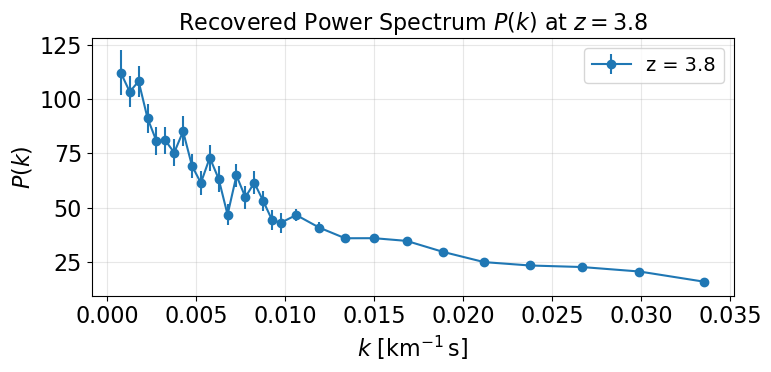

In [298]:
z_target = target_redshift
subset = df[df['z'] == z_target].copy()

# Recover P(k) and its uncertainty
subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

# Plot
plt.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], fmt='o-', label=f'z = {z_target}')
plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$P(k)$')
plt.title(f"Recovered Power Spectrum $P(k)$ at $z={z_target}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [299]:
def process_EDR_DATA(z_target):
    edr_data_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Examples/figure8_qmle_desiedrp_results.txt'

    # Read the file, using '|' as a separator and stripping whitespace
    df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
    df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
    df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
    df = df.apply(pd.to_numeric)               # Ensure all data is numeric

    subset = df[df['z'] == z_target].copy()
    
    # Recover P(k) and its uncertainty
    subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
    subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

    return subset['kc'], subset['Pk'], subset['Pk_err']

test_edr_k, test_edr_p, test_edr_err = process_EDR_DATA(target_redshift)

In [300]:
# plt.errorbar(test_edr_k, test_edr_p, test_edr_err, marker='o')

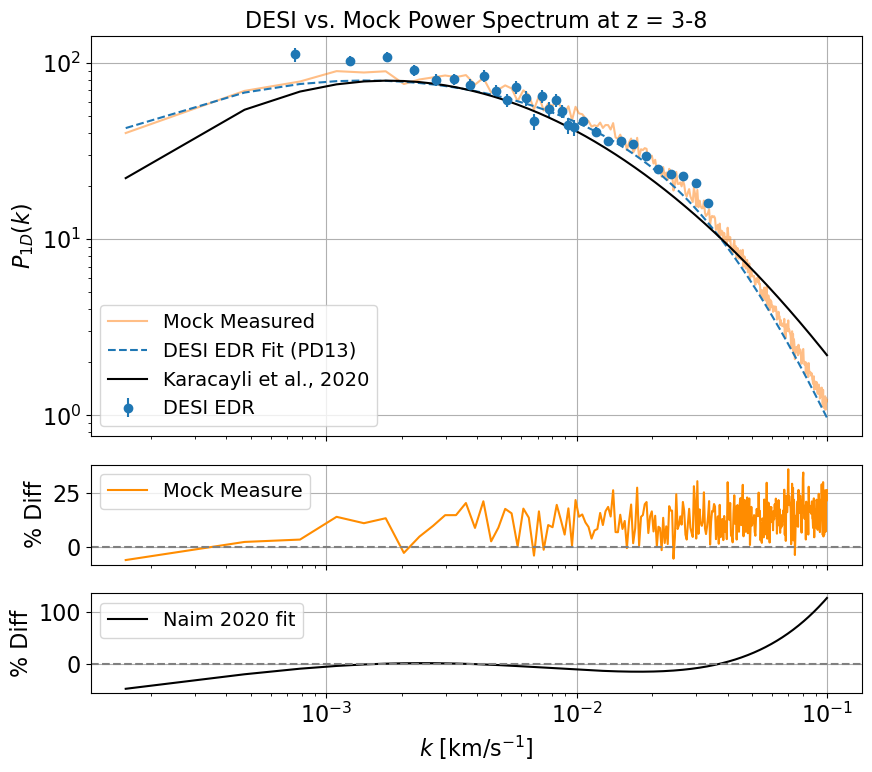

In [302]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1, 1]})

# Upper plot
ax1.loglog(bin_centers[w_k], stat[w_k], color='tab:orange', label='Mock Measured', alpha=0.5)
# ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
    color='tab:blue', label=r'DESI EDR Fit (PD13)', ls='--')
ax1.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], 
             fmt='o', label='DESI EDR', color='tab:blue')#, markerfacecolor='none')
ax1.loglog(bin_centers[w_k], naim_fit[w_k], 
    color='black', label=r'Karacayli et al., 2020')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')

# Lower plot (residuals)
ax2.semilogx(bin_centers[w_k], percent_diff_mock_measure[w_k], color='darkorange', label='Mock Measure')
# ax2.semilogx(bin_centers, percent_diff1, color='darkred', label='Mock Fit')
# ax2.semilogx(bin_centers, percent_diff2, color='black', label='Naim 2020')
ax2.axhline(0, ls='--', color='gray')
# ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.semilogx(bin_centers[w_k], percent_diff_naim_fit[w_k], color='black', label='Naim 2020 fit')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax3.set_ylabel('% Diff')
ax3.grid(True)

plt.legend()
plt.tight_layout()
plt.show()
